In [2]:
# from LengyelReinkeFormulation import LengFunc,returnImpurityFracLeng
from scipy.optimize import fsolve
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad,trapz, cumtrapz, odeint, solve_ivp
from scipy import interpolate
import ThermalFrontFormulation as TF
from unpackConfigurations import unpackConfiguration,returnzl,returnll
from matplotlib.collections import LineCollection
from AnalyticCoolingCurves import LfuncN,LfunLengFunccGauss,LfuncNe
from collections import defaultdict
import pandas as pd
import os
import pickle as pkl

%matplotlib inline
%load_ext autoreload
%autoreload 2
%aimport LengyelReinkeFormulation
from LengyelReinkeFormulation import *

# IO

In [3]:
studies = dict()
def file_write(data, filename):
# Writes an object to a pickle file.
    
    with open(filename, "wb") as file:
    # Open file in write binary mode, dump result to file
        pkl.dump(data, file)
        
        
        
def file_read(filename):
# Reads a pickle file and returns it.

    with open(filename, "rb") as filename:
    # Open file in read binary mode, dump file to result.
        data = pkl.load(filename)
        
    return data

## Read grids

In [202]:
#import geometry

paths = {"L":r"testGrids\\ConnectionLength\\",
        "BxBt":r"testGrids\\FluxExpansion\\",
        "B":r"testGrids\\pathing\\"}

cases = {"L":["L0.75", "L1.00", "L1.25", "L1.50"],
         "BxBt":["Angle0", "Angle11", "Angle30", "Angle90"],
         "B":["KinkAngle0Angle90", "KinkAngle23Angle67", "KinkAngle67Angle23", "KinkAngle90Angle0"]}

list_studies = ["L", "BxBt", "B"]

for study in list_studies:
    studies[study] = defaultdict(list)
    
    for i, file in  enumerate(cases[study]):

        gridFile = f"{paths[study]}{file}.nc"
        d = dict()
        d["zl"],d["TotalField"],d["Xpoint"],d["R0"],d["Z0"],d["R"],d["Z"], d["polLengthArray"], d["Bpol"], d["S"] = unpackConfiguration(gridFile,"Box",zxoverL = 0.7, returnSBool = True,polModulator = 1,sepadd = 0)
        d["Xpoint"] = len(d["S"])-1 # Code incorrectly defaults to an xpoint when in fact it's at edge of domain
        studies[study][i] = d

case_names = dict()
case_names["L"] = ["L0.75", "L1.00", "L1.25", "L1.50"]

In [203]:
d = studies["B"][2]
print("zl: distance from the target in z. Length:", d["zl"].shape)
print("TotalField: Btot, shape:", d["TotalField"].shape)
print("Xpoint, ID of xpoint along S (0-200)", d["Xpoint"])
print("R0: aka Rs. ??:", d["R0"].shape)
print("Z0: aka Zs. ??:", d["R0"].shape)
print("R: Grid coordinates in R (X axis):", d["R"].shape)
print("Z: Grid coordinates in Z (Y axis):", d["Z"].shape)
print("Bpol: array of length:", d["Bpol"].shape)
print("S: list of length:", len(d["S"]))

zl: distance from the target in z. Length: (10000,)
TotalField: Btot, shape: (10000,)
Xpoint, ID of xpoint along S (0-200) 9999
R0: aka Rs. ??: (10000,)
Z0: aka Zs. ??: (10000,)
R: Grid coordinates in R (X axis): (52, 332)
Z: Grid coordinates in Z (Y axis): (52, 332)
Bpol: array of length: (10000,)
S: list of length: 10000


## Read plot traces

In [288]:
fromplot = dict()
fromplot["fluxexpansion_dls"] = pd.read_csv(os.getcwd() + r"\csv\cyd_fluxexpansion_dls.csv", header = None, dtype = np.float64)
fromplot["fluxexpansion_solps"] = pd.read_csv(os.getcwd() + r"\csv\cyd_fluxexpansion_solps.csv", header = None, dtype = np.float64)
fromplot["length_dls"] = pd.read_csv(os.getcwd() + r"\csv\cyd_length_dls.csv", header = None, dtype = np.float64)
fromplot["length_solps"] = pd.read_csv(os.getcwd() + r"\csv\cyd_length_solps.csv", header = None, dtype = np.float64)

# Thermal front formulation

## Solve fronts

### Thermal front

In [204]:
#range of indices to choose for front position
indexrange = np.linspace(0,len(d["S"])-1000,5)
indexrange = list(indexrange.astype(int))

for study in list_studies:
    for case in range(4):
        #calculate C using simpler thermal front model
        d = studies[study][case]
        Sf = []
        Cf = []
        for i in indexrange:
            Sf.append(d["S"][i])
            # Solving for Xpoint at end?
            Cf.append(TF.CfInt(d["S"], d["TotalField"], 
                               d["S"][-1], #Xpoint
                               d["S"][-1],sh = d["S"][i],kappa1=2500))
        studies[study][case]["S_tf"] = Sf
        studies[study][case]["C_tf"] = Cf
    

### Lengyel Reinke

In [216]:
#set switches
radios = {
    "ionisation": False,  # in development
    "upstreamGrid": False, #if true, source of divertor heat flux comes from radial transport upstream, and Tu is at the midplane. If false, heat flux simply enters at the x point as qi, and Tu is located at the x point. 
    "fluxlim": False,  # if true, turns on a flux limiter with coefficient alpha
}

#set general run parameters
constants = {
    "gamma_sheath": 7, #sheath transmittion coefficient for virtual target. Choice does not matter if Tt is low
    "qpllu0": 5*10**9, # heat flux density at the x point
    "nu" : 1*10**19, #upstream density
    "kappa0" : 2500,
    "mi": 3*10**(-27),
    "echarge": 1.60*10**(-19), 
    "Tt": 0.5, # requested virtual target temp. Aim for low (sub 1eV) Tt
    "Lfunc": LfuncN, #impurity cooling function
    "alpha": 1000, #flux limiting alpha. Only matters if fluxlim is true

}

#### Length

In [217]:
for case in range(4):
    d = studies["L"][case]
    constants["XpointIndex"] = d["Xpoint"], # Index of Xpoint
    constants["B"] = interpolate.interp1d(d["S"], d["TotalField"], kind='cubic') # Continuous function for B
    splot,C,Sprofiles,Tprofiles,Qprofiles,log = returnImpurityFracLeng(constants,radios,d["S"],indexrange)
    d["C_lr"] = C

Solving...0...2250...4500...6750...9000...Complete.
Solving...0...2250...4500...6750...9000...Complete.
Solving...0...2250...4500...6750...9000...Complete.
Solving...0...2250...4500...6750...9000...Complete.


#### Flux expansion

In [207]:
for case in range(4):
    d = studies["BxBt"][case]
    constants["XpointIndex"] = d["Xpoint"], # Index of Xpoint
    constants["B"] = interpolate.interp1d(d["S"], d["TotalField"], kind='cubic') # Continuous function for B
    splot,C,Sprofiles,Tprofiles,Qprofiles,log = returnImpurityFracLeng(constants,radios,d["S"],indexrange)
    d["C_lr"] = C

Solving...0...2250...4500...6750...9000...Complete.
Solving...0...2250...4500...6750...9000...Complete.
Solving...0...2250...4500...6750...9000...Complete.
Solving...0...2250...4500...6750...9000...Complete.


#### Path

In [208]:
for case in range(4):
    d = studies["B"][case]
    constants["XpointIndex"] = d["Xpoint"], # Index of Xpoint
    constants["B"] = interpolate.interp1d(d["S"], d["TotalField"], kind='cubic') # Continuous function for B
    splot,C,Sprofiles,Tprofiles,Qprofiles,log = returnImpurityFracLeng(constants,radios,d["S"],indexrange)
    d["C_lr"] = C

Solving...0...2250...4500...6750...9000...Complete.
Solving...0...2250...4500...6750...9000...Complete.
Solving...0...2250...4500...6750...9000...Complete.
Solving...0...2250...4500...6750...9000...Complete.


In [209]:
file_write(studies, "studies.pkl")

In [200]:
studies = file_read("studies.pkl")

## Collect results

In [284]:
# Collect Cf results
out = dict()

# for study in ["BxBt"]:#list_studies:
for study in list_studies:
    out[study] = defaultdict(list)

    thresholds_tf = []
    thresholds_lr = []

    for i in range(4):
        thresholds_tf.append(studies[study][i]["C_tf"][0])
        thresholds_lr.append(studies[study][i]["C_lr"][0])

    for i in range(4):
        d = studies[study][i]
        out[study]["C_tf"] = thresholds_tf
        out[study]["C_lr"] = thresholds_lr
        out[study]["C_tfrel"] = thresholds_tf / thresholds_tf[0]
        out[study]["C_lrrel"] = thresholds_lr / thresholds_lr[0]
        out[study]["L"].append(d["S"][-1])
        out[study]["BxBt"].append(d["TotalField"][0] / d["TotalField"][-1])
        out[study]["BtBx"].append(d["TotalField"][-1] / d["TotalField"][0])

out["L"]["Lrel"] = out["L"]["L"] / min(out["L"]["L"])
out["BxBt"]["BxBtrel"] = out["BxBt"]["BxBt"] / out["BxBt"]["BxBt"][0]
out["BxBt"]["BtBxrel"] = out["BxBt"]["BtBx"] / out["BxBt"]["BtBx"][0]
out["BxBt"]["C_tfrel"] = out["BxBt"]["C_tf"] / out["BxBt"]["C_tf"][-1]
out["BxBt"]["C_lrrel"] = out["BxBt"]["C_lr"] / out["BxBt"]["C_lr"][-1]

### Length plot

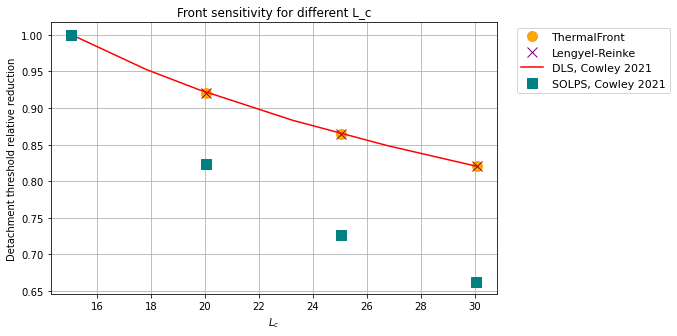

In [292]:
fig, ax = plt.subplots(figsize=(8,5))

ax.plot(out["L"]["L"], out["L"]["C_tfrel"], color = "orange", linewidth = 0, marker = "o", markersize= 10, label = "ThermalFront")
ax.plot(out["L"]["L"], out["L"]["C_lrrel"], color = "purple", linewidth = 0, marker = "x", markersize = 10, label = "Lengyel-Reinke")
ax.plot(fromplot["length_dls"][0], fromplot["length_dls"][1], color = "red", label = "DLS, Cowley 2021")
ax.plot(fromplot["length_solps"][0], fromplot["length_solps"][1], linewidth=0, marker="s", markersize=10, color = "teal", label = "SOLPS, Cowley 2021")

fig.legend(loc="upper right", bbox_to_anchor=(1.4,1), bbox_transform=ax.transAxes, fontsize = 11)
ax.set_title("Front sensitivity for different L_c")
ax.set_xlabel("$L_{c}$"); 
ax.set_ylabel("Detachment threshold relative reduction")
ax.grid(which="both")

### Flux expansion plot

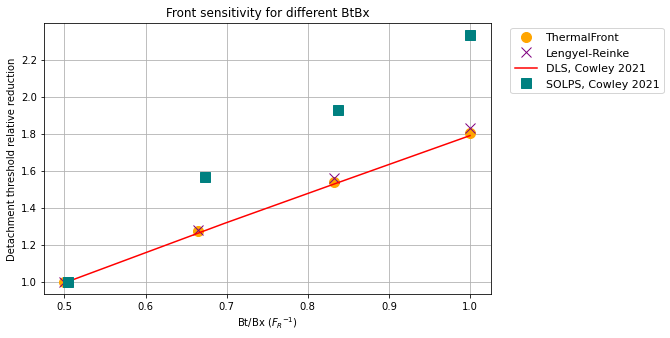

In [290]:
fig, ax = plt.subplots(figsize=(8,5))

ax.plot(out["BxBt"]["BxBt"], out["BxBt"]["C_tfrel"], color = "orange", linewidth = 0, marker = "o", markersize= 10, label = "ThermalFront")
ax.plot(out["BxBt"]["BxBt"], out["BxBt"]["C_lrrel"], color = "purple", linewidth = 0, marker = "x", markersize = 10, label = "Lengyel-Reinke")
ax.plot(fromplot["fluxexpansion_dls"][0], fromplot["fluxexpansion_dls"][1], color = "red", label = "DLS, Cowley 2021")
ax.plot(fromplot["fluxexpansion_solps"][0], fromplot["fluxexpansion_solps"][1], linewidth=0, marker="s", markersize=10, color = "teal", label = "SOLPS, Cowley 2021")

fig.legend(loc="upper right", bbox_to_anchor=(1.4,1), bbox_transform=ax.transAxes, fontsize = 11)
ax.set_title("Front sensitivity for different BtBx")
ax.set_xlabel("Bt/Bx (${F_{R}}^{-1}$)"); 
ax.set_ylabel("Detachment threshold relative reduction")
ax.grid(which="both")

### Total B plot

## Negative stability

In [4]:
#import geometry

paths = {"L":r"testGrids\\ConnectionLength\\",
        "BxBt":r"testGrids\\FluxExpansion\\",
        "B":r"testGrids\\pathing\\"}

cases = {"L":["L0.75", "L1.00", "L1.25", "L1.50"],
         "BxBt":["Angle0", "Angle11", "Angle30", "Angle90"],
         "B":["KinkAngle0Angle90", "KinkAngle23Angle67", "KinkAngle67Angle23", "KinkAngle90Angle0"]}

list_studies = ["L", "BxBt", "B"]



gridFile = r"testGrids\\stability.nc"
d = dict()
d["zl"],d["TotalField"],d["Xpoint"],d["R0"],d["Z0"],d["R"],d["Z"], d["polLengthArray"], d["Bpol"], d["S"] = unpackConfiguration(
    gridFile,"Box",zxoverL = 0.7, returnSBool = True,polModulator = 1,sepadd = 0)
d["Xpoint"] = len(d["S"])-1 # Code incorrectly defaults to an xpoint when in fact it's at edge of domain

data_stab = d

In [17]:
#range of indices to choose for front position
indexrange = np.linspace(0,len(d["S"])-100,1000)
indexrange = list(indexrange.astype(int))

for study in list_studies:
    for case in range(4):
        #calculate C using simpler thermal front model
        d = data_stab
        Sf = []
        Cf = []
        Spol = []
        for i in indexrange:
            Sf.append(d["S"][i])
            Spol.append(d["polLengthArray"][i])
            # Solving for Xpoint at end?
            Cf.append(TF.CfInt(d["S"], d["TotalField"], 
                               d["S"][-1], #Xpoint
                               d["S"][-1],sh = d["S"][i],kappa1=2500))
        d["S_tf"] = Sf
        d["C_tf"] = Cf
        d["Spol"] = Spol
    

(0.95, 1.05)

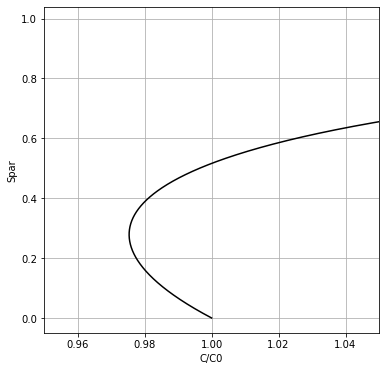

In [19]:
d["C_rel"] = d["C_tf"]/d["C_tf"][0]

fig, ax = plt.subplots(figsize=(6,6))
ax.plot(d["C_rel"], d["Spol"], color = "black")
ax.set_xlabel("C/C0")
ax.set_ylabel("Spar")
ax.grid()
ax.set_xlim(0.95, 1.05)

# Crap

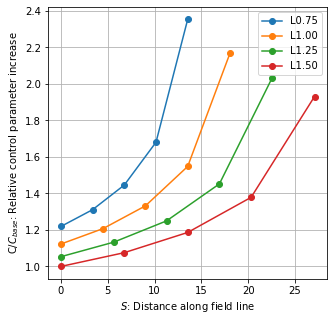

In [65]:
fig, ax = plt.subplots(figsize=(5,5))

for i in range(len(studies["L"])):  
    d = studies["L"][i]
    ax.plot(d["Sf"], d["Cfrel"], marker = "o", label = case_names["L"][i])

ax.legend(loc="best")
ax.set_ylabel("C/$C_{base}$: Relative control parameter increase"); 
ax.set_xlabel("$S$: Distance along field line")
ax.grid(which="both")


In [80]:
results = dict()
results["L"] = defaultdict(list)

for i in range(len(studies["L"])): 
    d = studies["L"][i]
    results["L"]["Cfrel"].append(d["Cfrel"][0])
    results["L"]["L"].append(d["S"][-1])
    
results["L"]["Lrel"] = results["L"]["Lrel"] / min(results["L"]["L"])

fromplot = dict()
fromplot["fluxexpansion"] = pd.read_csv(os.getcwd() + r"\csv\cyd_fluxexpansion.csv", header = None, dtype = np.float64)

thresholds = []
for case in list_BtBx:
    thresholds.append(Crel[case][0])

offset = -1
fig, ax = plt.subplots(figsize=(8,5))

ax.plot(results["L"]["L"], thresholds, color = "black", label = "Reproduction")
ax.scatter(fromplot["fluxexpansion"][0], fromplot["fluxexpansion"][1], color = "red", label = "Cowley 2021")
    
xlims = ax.axes.get_xlim()
# ax.hlines(d["S"][d["Xpoint"]], xlims[0], xlims[1], color = "black", linestyle = "dotted", label = "X-point")
# ax.hlines(0, xlims[0], xlims[1], color = "black", linestyle = "dashed", label = "Target")

fig.legend(loc="upper right", bbox_to_anchor=(1.3,1), bbox_transform=ax.transAxes, fontsize = 11)
ax.set_title("Front sensitivity for different BtBx")
ax.set_xlabel("Bt/Bx (${F_{R}}^{-1}$)"); 
ax.set_ylabel("Detachment threshold (m)")
ax.grid(which="both")
    

15.037653741165851
20.050138155095038
25.0626225690266
30.075106982955347


# Lengyel Reinke Formulation

In [77]:
results["L"]["L"]

[30.075106982955347]

In [60]:
#set switches
radios = {
    "ionisation": False,  # in development
    "upstreamGrid": False, #if true, source of divertor heat flux comes from radial transport upstream, and Tu is at the midplane. If false, heat flux simply enters at the x point as qi, and Tu is located at the x point. 
    "fluxlim": False,  # if true, turns on a flux limiter with coefficient alpha
}

#set general run parameters
constants = {
    "gamma_sheath": 7, #sheath transmittion coefficient for virtual target. Choice does not matter if Tt is low
    "qpllu0": 5*10**9, # heat flux density at the x point
    "nu" : 1*10**19, #upstream density
    "kappa0" : 2500,
    "mi": 3*10**(-27),
    "echarge": 1.60*10**(-19), 
    "Tt": 0.5, # requested virtual target temp. Aim for low (sub 1eV) Tt
    "Lfunc": LfuncN, #impurity cooling function
    "alpha": 1000, #flux limiting alpha. Only matters if fluxlim is true
    "XpointIndex":d["Xpoint"], # Index of Xpoint
    "B":interpolate.interp1d(S, d["TotalField"], kind='cubic') # Continuous function for B
}

In [23]:
indexpoints = [2000, 4000, 6000]
#set switches
radios = {
    "ionisation": False,  # in development
    "upstreamGrid": True, #if true, source of divertor heat flux comes from radial transport upstream, and Tu is at the midplane. If false, heat flux simply enters at the x point as qi, and Tu is located at the x point. 
    "fluxlim": False,  # if true, turns on a flux limiter with coefficient alpha
}

#set general run parameters
constants = {
    "gamma_sheath": 7, #sheath transmittion coefficient for virtual target. Choice does not matter if Tt is low
    "qpllu0": 5*10**9, # heat flux density at the x point
    "nu" : 1*10**19, #upstream density
    "kappa0" : 2500,
    "mi": 3*10**(-27),
    "echarge": 1.60*10**(-19), 
    "Tt": 0.5, # requested virtual target temp. Aim for low (sub 1eV) Tt
    "Lfunc": LfuncN, #impurity cooling function
    "alpha": 1000, #flux limiting alpha. Only matters if fluxlim is true
    "XpointIndex":int(len(d["S"])*0.8), # Index of Xpoint
    "B":interpolate.interp1d(d["S"], d["TotalField"], kind='cubic') # Continuous function for B
}
splot,C,Sprofiles,Tprofiles,Qprofiles, log = returnImpurityFracLeng(constants,radios,d["S"],indexpoints)
print("complete")

Solving...2000 ...4000 ...6000 ...Complete.
complete


In [8]:
d["Xpoint"]

9999

In [13]:
Qprofiles

[array([ 7.99611973e+06,  1.91463276e+09,  2.43355438e+09, ...,
         3.77578921e+06, -1.22921580e+06, -6.23422080e+06])]

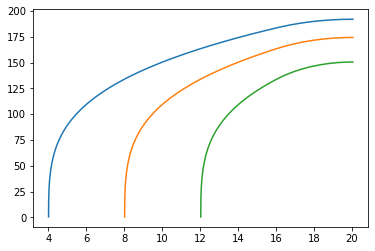

In [24]:
for i in range(len(Sprofiles)):
    plt.plot(Sprofiles[i], Tprofiles[i])

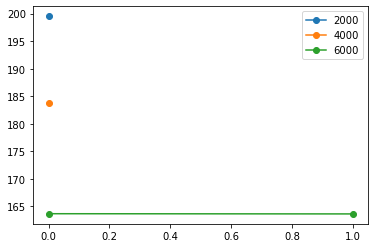

In [142]:
# for i in indexpoints:
#     plt.plot(log[i]["Tu"], label = i, marker = "o")
plt.legend()

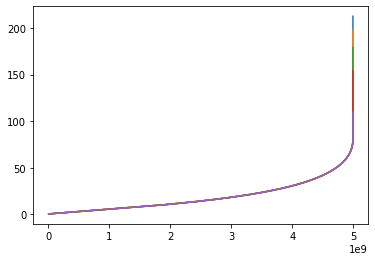

In [87]:
fig, ax = plt.subplots()
for i in range(len(Sprofiles)):
    ax.plot(Qprofiles[i], Tprofiles[i])


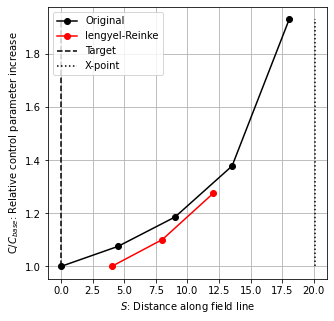

In [25]:
Crel = Cf/Cf[0]
fig, ax = plt.subplots(figsize=(5,5))
ax.plot(Sf, Crel, color = "black", marker = "o", label = "Original")
ax.plot(splot,C/C[0], label="lengyel-Reinke",color="red", marker = "o")

ax.vlines(0, Crel[0], Crel[-1], color = "black", linestyle = "dashed", label = "Target")
ax.vlines(d["S"][d["Xpoint"]], Crel[0], Crel[-1], color = "black", linestyle = "dotted", label = "X-point")
ax.legend(loc="best")
ax.set_ylabel("C/$C_{base}$: Relative control parameter increase"); 
ax.set_xlabel("$S$: Distance along field line")
ax.grid(which="both")


In [80]:
C

[9.369418696261274,
 10.077303414228114,
 11.1148828446548,
 12.925989018587142,
 18.157115646394693]

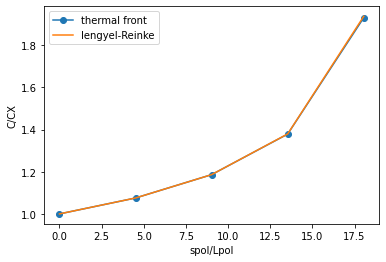

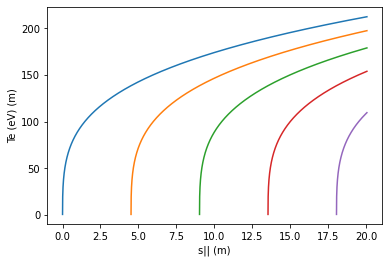

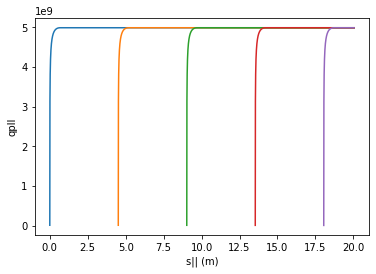

In [92]:
# %%
B =  interpolate.interp1d(S, TotalField, kind='cubic') # Why interpolate?

constants["XpointIndex"] = Xpoint
constants["B"] = interpolate.interp1d(S, TotalField, kind='cubic')

#calculate C using the Lengyel-Reinke model
splot,C,Sprofiles,Tprofiles,Qprofiles = returnImpurityFracLeng(constants,radios,S,indexrange)
# %%

# compare models against eachother
plt.plot(Sf,Cf/Cf[0],label="thermal front",color="C0",marker="o")
plt.plot(splot,C/C[0],label="lengyel-Reinke",color="C1")
plt.xlabel("spol/Lpol")
plt.ylabel("C/CX")
plt.legend()
plt.savefig("ControlParameter.png",dpi=400)
plt.show()

#plot temperature profiles from Lengyel-Reinke model
for i in range(len(Tprofiles)):
    plt.plot(Sprofiles[i],Tprofiles[i])
plt.ylabel("Te (eV) (m)")
plt.xlabel("s|| (m)")
plt.show()

#plot heat flux profiles from Lengyel-Reinke model
for i in range(len(Qprofiles)):
    plt.plot(Sprofiles[i],Qprofiles[i])
plt.ylabel("qpll")
plt.xlabel("s|| (m)")
plt.show()
# %%

In [59]:
B(4)

array(0.50503621)